#### Similar to the `compare lig_res_interactions_by_type`, the goal here is compare interactions between simulations, only here is about specific residues, not specific interactions

This used to be a same part of that script when it was a sandbox script, but I figured it would be best that this is alone now


This is going to be used to measure how interactions are between conditions (eg showing that crystal sims don't have very different fingerprints, whereas EM does)

In [241]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import prolif as plf
import MDAnalysis as mda
import pandas as pd
import seaborn as sns

sys.path.append('../')
import src.analysis_functions as analysis_functions
import src.simulation_metadata as sims
from src.figure_parameters import figure_rc_params
import matplotlib as mpl

In [242]:
crystal_or_em = 'em_binding_fp'

if crystal_or_em == 'crystal_binding_fp':
    sim_list = [sims.PfHT_MMV_crystal, 
                sims.PfHT_MMV8_crystal, 
                sims.W412A_MMV_crystal,
                sims.GLUT3_MMV_crystal
                ]
elif crystal_or_em == 'em_binding_fp':
    sim_list = [sims.PfHT_MMV12, 
                sims.PfHT_MMV8, 
                sims.W412A_MMV12,
                sims.GLUT1_MMV12
                ]

color_l = [sim.color for sim in sim_list]

all_unis, all_lens = analysis_functions.load_unis(
    sim_list= sim_list
)


In [243]:
all_fp_dfs = {}
skip = 1

for sim in sim_list:
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[sim.name]):
        df = analysis_functions.get_fp_dataframe(
            u=rep_fp,
            skip=skip,
            run_calc=False,
            filename=f"{sim.name}.replica_{n+1}.skip{skip}",
        )
        temp_fp_dfs.append(df)
    all_fp_dfs[sim.name] = temp_fp_dfs


# Calculate percentage of whatever interaction you want
Just find where t.ex TRP412 (or equivalent) is in the dataframe, then take mean

#### Pt 1 - First function `mean_intxns_per_res_wide` will output a df for one residue. You can plot this directly comparing interaction types

##### `res_map` will help with residue numbering and labeling, since it's different between PfHT and GLUTs osv

In [244]:
res_map = {"W412":{'PfHT1':'TRP391', 'GLUT1':'TRP381', 'GLUT3':'TRP386'},
           "Q169":{'PfHT1':'GLN148', 'GLUT1':'GLN154', 'GLUT3':'GLN159'},
           "Q305":{'PfHT1':"GLN284", 'GLUT3':'GLN280', 'GLUT1':'GLN275'},
           "Q306":{'PfHT1':"GLN285", 'GLUT3':'GLN281', 'GLUT1':'GLN276'},
           "N341":{'PfHT1':'ASN320', 'GLUT3':'ASN315', 'GLUT1':'ASN310'},
           "N311":{"PfHT1":'ASN290', 'GLUT3':'ASN286', 'GLUT1':'ASN281'},
           "W436":{"PfHT1":'TRP415', 'GLUT3':'TRP410', 'GLUT1':'TRP405'},
           "A404":{"PfHT1":'ALA383', 'GLUT3':'GLU378', 'GLUT1':'GLU373'},
           "S315":{"PfHT1":'SER294', 'GLUT3':'TYR290', 'GLUT1':'TYR285'}, #for crystal str
           'S432':{'PfHT1':'SER411', 'GLUT1':'GLY401'}, ## now this is EM binding site
           'T173':{'PfHT1':'THR152', 'GLUT1':'VAL158'},
           'L411':{'PfHT1':'LEU390', 'GLUT1':'PRO380'},
           
           }

res= 'W412'


#### then, use the `get_mean_intxn` and `wide_df_of_reps_conds` function to get the mean interactions per residue. 
return a wide dataframe with the top level being protein condition, the lower level being the replica, and index being interaction type

In [280]:
def mean_intxn_by_type(
        fp_df: pd.DataFrame,
        sim: sims.SimulationMetadata,
        resname: str,
        res_map: dict=res_map,
        mean_cutoff: int=0.1
) -> pd.Series:
    ''' 
    Calculate mean interaction time in a fingerprint df

    Return a pandas series with index as interaction types
    '''

    ## need conditional for W412A sims
    if 'W412' in sim.name and resname == 'W412':
        if 'ALA391' in fp_df:
            mean_intxn = fp_df['ALA391'].mean()
        else:
            mean_intxn = pd.Series([], name='interaction')
    
    else:
        if res_map[resname][sim.protein] in fp_df:
            mean_intxn = fp_df[res_map[resname][sim.protein]].mean()
        else:
            mean_intxn = pd.Series([], name='interaction')
    
    mean_intxn = mean_intxn.loc[mean_intxn > mean_cutoff]

    return mean_intxn

In [308]:
def mean_intxn_combined(
        fp_df: pd.DataFrame,
        sim: sims.SimulationMetadata,
        resname: str,
        res_map: dict=res_map,
        drop_interactions: list=['Hydrophobic', 'VdWContact'],
        mean_cutoff: int=0.1
) -> pd.Series:
    ''' 
    Calculate mean interaction time in a fingerprint df, combined across intxns
    (so if both HBAcceptor and PiStacking, counts as one, if not anything, counts as zero)

    Return a pandas series with "Contact" as index
    '''

    mapped_resname = res_map[resname][sim.protein]
    
    ## need conditional for W412A sims
    if 'W412' in sim.name and resname == 'W412':
        mapped_resname = 'ALA391'

    if mapped_resname in fp_df:

        n_zeros = (
            fp_df[mapped_resname]
            .drop(columns=drop_interactions, errors='ignore')
            .mean(axis=1)
            .value_counts()
        )
        
        if 0 in n_zeros and not n_zeros.empty:
            n_zeros = n_zeros[0]
        elif n_zeros.empty:   #sometimes, only intxns are ones dropped, need to assign 100% zeros if so
            n_zeros = len(fp_df)
        else:
            n_zeros = 0  # if you can't find any zeros and n_zeros exists, make n_zeros == 0 (means 100% binding)
    else:
        n_zeros = len(fp_df)  # all zeros if you can't find
    
    n_zeros = (len(fp_df) - n_zeros) / len(fp_df)
    if n_zeros < mean_cutoff:
        n_zeros = 0 
    
    mean_intxn = pd.Series(index=['Contact'], data=n_zeros, name='interaction')
    return mean_intxn

In [309]:
test = mean_intxn_combined(all_fp_dfs[sims.W412A_MMV12.name][1],
                    sim=sims.W412A_MMV12,
                    resname='W412',
                    drop_interactions=['Hydrophobic', 'VdWContact'])

test

Contact    0
Name: interaction, dtype: int64

In [310]:
def wide_df_of_reps_conds(
        resname: str,
        all_fp_dfs: dict=all_fp_dfs,
        res_map: dict=res_map,
        sim_list: list=sim_list,
        mean_cutoff: int=0.1,
        by_type_or_combined: str='combined',
) -> pd.DataFrame:
    '''
    Will loop through the sim_list
    For each element in list, loop through all reps of this element, finding the 
    fingerprint for the given residue. This is dictated by res_map, seen in the cell above
    then combine all conditions, left with a wide dataframe called mean_intxn_all_conds
    '''
    
    mean_intxn_all_conds = {}
    for sim in sim_list:
        replica_names = [f"replica {i}" for i in range(1, sim.n_replicas + 1)]

        ### group replicas as cols into a wide dataframe
        mean_intxn_all_reps = []
        for rep in all_fp_dfs[sim.name]:

            if by_type_or_combined == 'by_type':
                mean_intxn = mean_intxn_by_type(fp_df=rep,
                                            sim=sim,
                                            resname=resname)
            
            elif by_type_or_combined == 'combined':
                mean_intxn = mean_intxn_combined(fp_df=rep,
                                            sim=sim,
                                            resname=resname)
            


            mean_intxn_all_reps.append(mean_intxn)
        mean_intxn_all_reps = pd.concat(mean_intxn_all_reps, axis=1, keys=replica_names)
        
        ### then group conditions as cols into wide(r) dataframe
        mean_intxn_all_conds[sim.name] = mean_intxn_all_reps
    mean_intxn_all_conds = pd.concat(mean_intxn_all_conds, axis=1)
    mean_intxn_all_conds.index.name='interaction' #somehow this gets lost
    return mean_intxn_all_conds

In [311]:
mean_intxn_all_conds = wide_df_of_reps_conds(
                                            resname=res,
                                            sim_list=sim_list,
                                            all_fp_dfs=all_fp_dfs
                                        )

mean_intxn_all_conds

PfHT_MMV12                     PfHT_MMV8                      \
             replica 1 replica 2 replica 3 replica 1 replica 2 replica 3   
interaction                                                                
Contact       0.948052  0.342657  0.584416  0.126126  0.108889         0   

            W412A_MMV12                     GLUT1_MMV12                      
              replica 1 replica 2 replica 3   replica 1 replica 2 replica 3  
interaction                                                                  
Contact               0         0         0           0  0.545029         0

Here it makes life a bit easier to add a conditional for if we want to see all interactions, or just the "contact" ones

In [202]:
show_only_contact = True

if show_only_contact:
    mean_intxn_all_conds = all_intxns_per_res_wide(
                                                resname=res,
                                                sim_list=sim_list,
                                                all_fp_dfs=all_fp_dfs
                                            )
else:
    mean_intxn_all_conds = mean_intxns_per_res_wide(
                                                resname=res,
                                                sim_list=sim_list,
                                                all_fp_dfs=all_fp_dfs
                                            )


In [218]:
df = all_fp_dfs[sims.PfHT_MMV12.name][0]

'TRP391' in df

True

Since we want the order of the bar graphs to be the same, and contain same info, reindex on `intxn_index`
- This will therefore automatically keep this order, and drop other interactions I don't care about, like Hydrophobic
- Do `fillna` after to make all `nan` zero, so they appear on the bar graph as zeros

In [203]:
if show_only_contact:
    intxn_index = {'Contact':[]}
else:
    intxn_index = {'HBAcceptor':[], 'HBDonor':[], 'VdWContact':[], 'PiStacking':[]}
mean_intxn_all_conds = mean_intxn_all_conds.reindex(intxn_index).fillna(0)
mean_intxn_all_conds

PfHT_MMV12                     PfHT_MMV8                      \
             replica 1 replica 2 replica 3 replica 1 replica 2 replica 3   
interaction                                                                
Contact              0         0         0         0         0         0   

            W412A_MMV12                     GLUT1_MMV12                      
              replica 1 replica 2 replica 3   replica 1 replica 2 replica 3  
interaction                                                                  
Contact               0       1.0         0           0         0         0

#### use `analysis_functions.process_df_wide` to make this into a long form dataframe

In [195]:
mean_intxn_all_conds = analysis_functions.process_wide_df(
    df=mean_intxn_all_conds,
    index_col_name='interaction',
    index_name='interaction',
    top_level_melt_name='protein',
    lower_level_melt_name='replica'
)


#### plot in seaborn

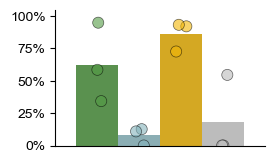

In [196]:
with mpl.rc_context(figure_rc_params):
    f,ax=plt.subplots(1,1, figsize=(3,2))
    g = sns.barplot(data=mean_intxn_all_conds,
                y='value', 
                x='interaction', 
                hue='protein',
                ax=ax,
                errorbar=None,
                palette=color_l
                )
    g.legend_.remove()

    sns.stripplot(
        data=mean_intxn_all_conds,
        y='value',
        x='interaction',
        hue='protein',
        ax=ax,
        dodge=True,
        alpha=0.6,
        edgecolor="black",
        linewidth=0.5,
        legend=False,
        size=8,
        palette=color_l
    )
    ax.set_xticks(ax.get_xticks(), 
    ax.get_xticklabels(),
    rotation=20,
    fontsize=8,
    )
    ax.tick_params(axis='x', which='major', pad=0.2)
    ax.set_xticks([])
    ax.set_xlabel(None)

    ax.set_ylim(0,1.05)
    #ax.set_ylabel('Frequency of interaction', labelpad=0.002)
    ax.set_ylabel(None)
    #ax.set_yticks(ax.get_yticks(), np.array(ax.get_yticks()*100).astype(int))
    ax.set_yticks([0,0.25,0.5,0.75,1], ['0%', '25%', '50%', '75%', '100%'])
    
    ax.spines[['right', 'top']].set_visible(False)
    plt.subplots_adjust(bottom=0.2, left=0.2)

    if show_only_contact:
        plt.savefig(f'../../../images_paper/simulations/fingerprints/{crystal_or_em}.only_contact.{res}.svg')
    else:
        plt.savefig(f'../../../images_paper/simulations/fingerprints/{crystal_or_em}.by_type.{res}.svg')


plt.show()